# Karol Kot s15259 INL

TASK URL: http://2019.poleval.pl/index.php/tasks/task6
Code was tested using anaconda python3.11

In [9]:
!conda install -y tensorflow[and-cuda] scikit-learn matplotlib wordcloud spacy numpy

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /home/karol/anaconda3/envs/Archive1

  added / updated specs:
    - matplotlib
    - numpy
    - scikit-learn
    - spacy
    - tensorflow
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20211102.0      |       hd4dd3e8_0        1020 KB
    abs

In [74]:
import tensorflow as tf
import matplotlib.pyplot as plt
import spacy
import time
import subprocess
import os
import random
import time
import numpy as np

from collections import Counter
from tensorflow import keras
from wordcloud import WordCloud
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from spacy.util import minibatch, compounding
from spacy.scorer import Scorer
from spacy.lang.pl.stop_words import STOP_WORDS as stop_words_spacy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from spacy.training import Example

%matplotlib inline

print(tf.config.list_physical_devices())

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. ANN can be very slow without a GPU.")

result = subprocess.run(['python3', '-m', 'spacy', 'info', 'pl_core_news_sm'], stdout=subprocess.PIPE)
stdout = result.stdout

if 'Info about model' in str(stdout):
    subprocess.run(['python3', '-m', 'spacy', 'download', 'pl_core_news_sm'], stdout=subprocess.PIPE)

!python3 -m spacy download pl_core_news_sm
nlp = spacy.load("pl_core_news_sm")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


DEPRECATION: https://github.com/explosion/spacy-models/releases/download/pl_core_news_sm-2.3.0/pl_core_news_sm-2.3.0.tar.gz#egg=pl_core_news_sm==2.3.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/pl_core_news_sm-2.3.0/pl_core_news_sm-2.3.0.tar.gz#egg=pl_core_news_sm==2.3.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Using cached pl_core_news_sm-2.3.0-py3-none-any.whl
‚úî Download and installation successful
You can now load the model via spacy.load('pl_core_news_sm')


In [85]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2024-01-11 22:20:41.935100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 22:20:41.940230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 22:20:41.940276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 22:20:42.490055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 22:20:42.490265: I external/local_xla/xla/stream_executor

In [75]:
def read_file(path, strip=True):
    with open(path, encoding='utf8') as file:
        data = file.readlines()
    if strip: data = [line.strip() for line in data]
    return data


def convert_labels_to_textcat(labels, categories):
    return [categories[label] for label in labels]


def load_poleval_data(labels_text_categories=None, task_number=1):
    train_comments_path = os.path.join(f'task_6-{task_number}', 'training_set_clean_only_text.txt')
    train_labels_path = os.path.join(f'task_6-{task_number}', 'training_set_clean_only_tags.txt')
    test_comments_path = os.path.join('Task6', f'task_0{task_number}', 'test_set_clean_only_text.txt')
    test_labels_path = os.path.join('Task6', f'task_0{task_number}', 'test_set_clean_only_tags.txt')

    train_comments = read_file(train_comments_path)
    train_labels = read_file(train_labels_path)
    test_comments = read_file(test_comments_path)
    test_labels = read_file(test_labels_path)

    if labels_text_categories is not None:
        train_labels = [labels_text_categories[label] for label in train_labels]
        test_labels = [labels_text_categories[label] for label in test_labels]
        print('> Labels converted to textcat format.')

    return (train_comments, train_labels), (test_comments, test_labels)

# 2. Data exploration

### Labels distribution (train, test)

In [76]:
def plot_most_common(txt_comments, top=20, title=''):
    values, labels = get_most_common(txt_comments, top)
    x = range(len(values))

    plt.figure(figsize=(15, 5))
    plt.bar(x, values)
    plt.xticks(x, labels, rotation=90)
    plt.title(title)
    plt.show()


def get_most_common(txt, top=20):
    words = (txt).split()
    print(f'Found {len(words)} words.')
    most_common = Counter(words).most_common(top)
    labels = []
    values = []
    for label, val in most_common:
        labels.append(label)
        values.append(val)
    return values, labels


def clean_up(comments: list) -> list:
    replace = {'@anonymized_account': '',
               'rt': ''}
    new_comments = []
    for comment in comments:
        comment = comment.lower()
        for old, new in replace.items():
            comment = comment.replace(old, new)
        new_comments.append(comment.strip())
    return new_comments


def wordcloud_plot(text: str, stop_words=None, bg='white'):
    wordcloud = WordCloud(stopwords=stop_words,
                          min_font_size=5,  #4
                          max_words=150,  #200
                          background_color=bg,
                          ).generate(text)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.plot()


def predictionsV2(nlp, comments, labels, categories):
    y_true = []
    y_pred = []

    for idx, comment in enumerate(comments):
        doc = nlp(comment)
        predicted = max(doc.cats.keys(), key=lambda k: doc.cats[k])
        expected = categories[labels[idx]]

        if type(predicted) is not int:
            predicted = categories[predicted]

        if type(expected) is not int:
            expected = categories[expected]

        y_pred.append(predicted)
        y_true.append(expected)

    print(f'y_true: {Counter(y_true)}')
    print(f'y_pred: {Counter(y_pred)}\n')
    return y_true, y_pred


def accuracy(nlp, comments, labels):
    y_true, y_pred = predictionsV2(nlp, comments, labels)
    return accuracy_score(y_true, y_pred)


def print_evaluation_metricsV2(nlp, comments, labels, categories):
    y_true, y_pred = predictionsV2(nlp, comments, labels, categories)
    precision = 2
    acc = round(accuracy_score(y_true, y_pred) * 100, precision)
    prec = round(precision_score(y_true, y_pred, average="micro") * 100, precision)
    f1 = round(f1_score(y_true, y_pred, average="micro") * 100, precision)
    rec = round(recall_score(y_true, y_pred, average="micro") * 100, precision)

    fmt = '| %10s | %10s | %10s | %10s |'
    print(fmt % ('Accuracy', 'Precision', 'F1-Score', 'Recall'))
    print(fmt % (f'{acc}%', f'{prec}%', f'{f1}%', f'{rec}%'))


def get_dictionary_from_label_and_categories(label, categories):
    cat_dictionary = {}
    for category in categories.values():
        cat_dictionary[category] = label == category
    return cat_dictionary


def format_train_data(train_comments: list, train_labels: list, categories) -> list:
    '''
    comments = ['bully_comment', 'non_bully_comment']
    labels = [{'NEGATIVE': False, 'POSITIVE': True}, {'NEGATIVE': True, 'POSITIVE': False}]
    format_train_data(comments, labels)
    >>> [('bully_comment', {'cats': {'NEGATIVE': False, 'POSITIVE': True}}),
         ('non_bully_comment', {'cats': {'NEGATIVE': True, 'POSITIVE': False}})]
    '''
    return list(zip(train_comments,
                    [{"cats": get_dictionary_from_label_and_categories(label, categories)} for label in train_labels]))


def lemmatize(comments: list, nlp: spacy) -> list:
    def is_redundant(token):
        return any([token.is_punct, token.is_stop, token.is_space])

    return [' '.join([token.lemma_ for token in nlp(comment) if not is_redundant(token)]) for comment in comments]


def train(train_data, categories, nlp=None, model=None, epochs=10, dropout=0.2, save_note=''):
    if nlp is None:
        if model is not None:
            nlp = spacy.load("pl_core_news_sm")
            print(f'Loaded model {model}')
        else:
            nlp = spacy.blank('pl')
            print('Loaded blank "pl" model.')

    config = {}

    if "textcat" not in nlp.pipe_names:
        nlp.add_pipe('textcat', config=config, last=True)
        
    textcat = nlp.get_pipe("textcat")
    for key in categories.keys():
        if type(key) is str and key.isdigit() is False:
            print(f"KEY ADDED: {key}")
            textcat.add_label(key)

    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()

        print("Training the model...")
        batch_sizes = compounding(4.0, 32.0, 1.001)
        for epoch in range(epochs):
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                examples = []
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    examples.append(example)
                
                nlp.update(examples, sgd=optimizer, drop=dropout, losses=losses)
            print(f"Epoch executed: {epoch}")

    timestamp = round(time.time() * 100)
    filename = f'nlp_spacy_model_{timestamp}_{save_note}'
    with nlp.use_params(optimizer.averages):
        nlp.to_disk(filename)
    print(f'> Saved model as {filename}')

    return (nlp, filename)


def explore_data(train_x, train_y, test_x, test_y, categories):
    stop_words = ['ach', 'aj', 'albo', 'bardzo', 'bez', 'bo', 'byƒá', 'ci', 'ciƒô', 'ciebie', 'co', 'czy', 'daleko',
                  'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokƒÖd', 'do≈õƒá', 'du≈ºo', 'dwa', 'dwaj', 'dwie', 'dwoje',
                  'dzi≈õ', 'dzisiaj', 'gdyby', 'gdzie', 'go', 'ich', 'ile', 'im', 'inny', 'ja', 'jƒÖ', 'jak', 'jakby',
                  'jaki', 'je', 'jeden', 'jedna', 'jedno', 'jego', 'jej', 'jemu', 'je≈õli', 'jest', 'jestem', 'je≈ºeli',
                  'ju≈º', 'ka≈ºdy', 'kiedy', 'kierunku', 'kto', 'ku', 'lub', 'ma', 'majƒÖ', 'mam', 'mi', 'mnƒÖ', 'mnie',
                  'moi', 'm√≥j', 'moja', 'moje', 'mo≈ºe', 'mu', 'my', 'na', 'nam', 'nami', 'nas', 'nasi', 'nasz', 'nasza',
                  'nasze', 'natychmiast', 'niƒÖ', 'nic', 'nich', 'nie', 'niego', 'niej', 'niemu', 'nigdy', 'nim', 'nimi',
                  'ni≈º', 'obok', 'od', 'oko≈Ço', 'on', 'ona', 'one', 'oni', 'ono', 'owszem', 'po', 'pod', 'poniewa≈º',
                  'przed', 'przedtem', 'sƒÖ', 'sam', 'sama', 'siƒô', 'skƒÖd', 'tak', 'taki', 'tam', 'ten', 'to', 'tobƒÖ',
                  'tobie', 'tu', 'tutaj', 'twoi', 'tw√≥j', 'twoja', 'twoje', 'ty', 'wam', 'wami', 'was', 'wasi', 'wasz',
                  'wasza', 'wasze', 'we', 'wiƒôc', 'wszystko', 'wtedy', 'wy', '≈ºaden', 'zawsze', '≈ºe', 'z', 'do', 'na',
                  'bez', 'za', 'pod', 'u', 'w', 'nad', 'o', 'od', 'po', 'a', 'i', 'oraz', 'tudzie≈º', 'ale', 'jednak',
                  'lecz', 'natomiast', 'za≈õ', 'czyli', 'mianowicie', 'poniewa≈º', 'dlatego', 'przeto', 'tedy', 'wiƒôc',
                  'zatem', 'tote≈º']

    def get_unique_chars(text):
        return ''.join(sorted(set(text.lower())))

    def shows_first_n(labels, comments):
        for idx, (label, comment) in enumerate(zip(labels, comments)):
            print(fmt % (label, comment))
            if idx >= 5:
                break

    fmt = '| %5s | %s'

    print('\nTrain examples')
    shows_first_n(train_y, train_x)

    print('\nTest examples')
    shows_first_n(test_y, test_x)

    n = len(train_y + test_y)
    print(f'number of train_comments: {len(train_x)} ({round(len(train_x) / n * 100, 2)}%).')
    print(f'number of test_comments: {len(test_x)} ({round(len(test_x) / n * 100, 2)}%).')
    print(f'total: {n}')

    counter = Counter(train_y + test_y)

    for key in counter.keys():
        print(f'number of "{key}" comments: {counter[key]} ({round(counter[key] / n * 100, 2)}%).')

    txt_comments = ' '.join(train_x + test_x).lower()
    print(get_unique_chars(txt_comments))
    plot_most_common(txt_comments, top=30, title='Top 30 most common words in train set')
    print([com for com in train_x if 'RT' in com][:10])

    x_clean = clean_up(train_x + test_x)
    txt_train = ' '.join(x_clean)
    wordcloud_plot(txt_train, stop_words)
    plot_most_common(txt_train, top=30, title='Top 30 most common words in cleaned train set')

    for key in counter.keys():
        print(f'number of "{key}" comments: {counter[key]} ({round(counter[key] / n * 100, 2)}%).')
        category_comments = [comment for (comment, label) in zip(x_clean, train_y + test_y) if label == key]
        txt_comments = ' '.join(category_comments)

        plot_most_common(txt_comments, top=30, title=f'Top 30 most common words in "{key}" comments set')
        wordcloud_plot(txt_comments, stop_words, bg='black')

In [77]:
def check_unbalanced_nlp_model(train_x, train_y, test_x, test_y, categories):
    nlp = spacy.load("pl_core_news_sm")
    train_x = clean_up(train_x)
    train_comments_lemma = lemmatize(train_x, nlp)

    train_data = format_train_data(train_comments_lemma, train_y, categories)
    t0 = time.perf_counter()
    nlp, filename = train(train_data,
                          categories,
                          nlp=nlp,
                          epochs=10,
                          dropout=0.2,
                          save_note='unbalanced')

    seconds = round(time.perf_counter() - t0, 4)
    minutes = round(seconds / 60, 2)

    print(f'\n\nTook {seconds} second(s) ~{minutes} minute(s).')
    print_evaluation_metricsV2(nlp, test_x, test_y, categories)


def check_balanced_nlp_model(train_x, train_y, test_x, test_y, categories):
    all_comments = train_x + test_x
    all_labels = train_y + test_y

    counter = Counter(all_labels)
    print(counter)

    for key in counter.keys():
        proportion = round(counter[key] / len(all_labels) * 100, 2)
        print(f'There is {proportion}% of "{key}" comments')

    to_take = min(counter.values())
    print(to_take)
    data = []
    for category in counter.keys():
        category_data = [(comment, label) for (comment, label) in zip(all_comments, all_labels) if label == category]
        random.shuffle(category_data)
        data = data + category_data[:to_take]

    random.shuffle(data)
    print(f"Balanced data len: {len(data)}")

    fmt = '%4s | %s'
    for comment, label in data[:5]:
        print(fmt % (label, comment))

    train_ratio = 0.8
    train_size = int(len(data) * train_ratio)

    train_balanced = data[:train_size]
    test_balanced = data[train_size:]

    print(len(train_balanced))
    print(len(test_balanced))

    train_comments_balanced = np.array(train_balanced)[:, 0]
    train_labels_balanced = np.array(train_balanced)[:, 1]
    train_comments_balanced = clean_up(train_comments_balanced)
    train_comments_balanced_lemmat = lemmatize(train_comments_balanced, nlp)

    fmt = '%s | %s'
    for comment, label in zip(train_comments_balanced_lemmat[:5], train_labels_balanced[:5]):
        print(fmt % (label, comment))

    train_data_balanced = format_train_data(train_comments_balanced_lemmat, train_labels_balanced, categories)
    t0 = time.perf_counter()
    nlp_balanced, filename = train(train_data_balanced,
                                   categories,
                                   nlp=None,
                                   epochs=10,
                                   dropout=0.2,
                                   save_note='balanced')

    print_evaluation_metricsV2(nlp_balanced, test_x, test_y, categories)


def check_logistict_regression(train_x, train_y, test_x, test_y, categories, avarage="binary"):
    train_comments_lemma = lemmatize(train_x, nlp)
    test_comments_clean = clean_up(test_x)
    test_comments_lemma = lemmatize(test_comments_clean, nlp)

    cv = CountVectorizer(binary=True)
    cv.fit(train_comments_lemma)
    X = cv.transform(train_comments_lemma)
    X_test = cv.transform(test_comments_lemma)

    train_labels_binary = [int(categories[label]) for label in train_y]
    test_labels_binary = [int(categories[label]) for label in test_y]

    parameters = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
                  'C': [0.01, 0.1, 1, 2, 4]}

    lr = LogisticRegression(n_jobs=-1, max_iter=10000)
    clf = GridSearchCV(lr, parameters)
    clf.fit(X, train_labels_binary)

    print("Best parameter (CV score=%0.3f):" % clf.best_score_)
    print(clf.best_params_)

    final_model = clf.best_estimator_
    final_model.fit(X, train_labels_binary)

    y_pred = final_model.predict(X_test)
    acc = accuracy_score(test_labels_binary, y_pred)
    f1 = f1_score(test_labels_binary, y_pred, average=avarage)
    prec = precision_score(test_labels_binary, y_pred, average=avarage)
    rec = recall_score(test_labels_binary, y_pred, average=avarage)

    precision = 2
    print(f"Accuracy: {round(acc * 100, precision)}%")
    print(f"Precision: {round(prec * 100, precision)}%")
    print(f"f1_score: {round(f1 * 100, precision)}%")
    print(f"Recall: {round(rec * 100, precision)}%")

> Labels converted to textcat format.

Train examples
| NEGATIVE | Dla mnie faworytem do tytu≈Çu bƒôdzie Cracovia. Zobaczymy, czy typ siƒô sprawdzi.
| NEGATIVE | @anonymized_account @anonymized_account Brawo ty Daria kibic ma byƒá na dobre i z≈Çe
| NEGATIVE | @anonymized_account @anonymized_account Super, polski premier sk≈Çada kwiaty na grobach kolaborant√≥w. Ale doczekali≈õmy czas√≥w.
| NEGATIVE | @anonymized_account @anonymized_account Musi. Innej drogi nie mamy.
| NEGATIVE | Odrzut natychmiastowy, kwa≈õna mina, mam problem
| NEGATIVE | Jaki on by≈Ç fajny xdd pamiƒôtam, ≈ºe sp√≥≈∫ni≈Çam siƒô na jego pierwsze zajƒôcia i to sporo i za karƒô kaza≈Ç mi usiƒÖ≈õƒá w pierwszej ≈Çawce XD

Test examples
| NEGATIVE | @anonymized_account Spoko, jak im Duda z Morawieckim zam√≥wiƒÖ po piƒôƒá piw to wszystko bƒôdzie ok.
| NEGATIVE | @anonymized_account @anonymized_account Ale on tu nie mia≈Ç szans jej zagrania, a ta 'proba' to czysta prowizorka.
| NEGATIVE | @anonymized_account No czy Prezes nie 

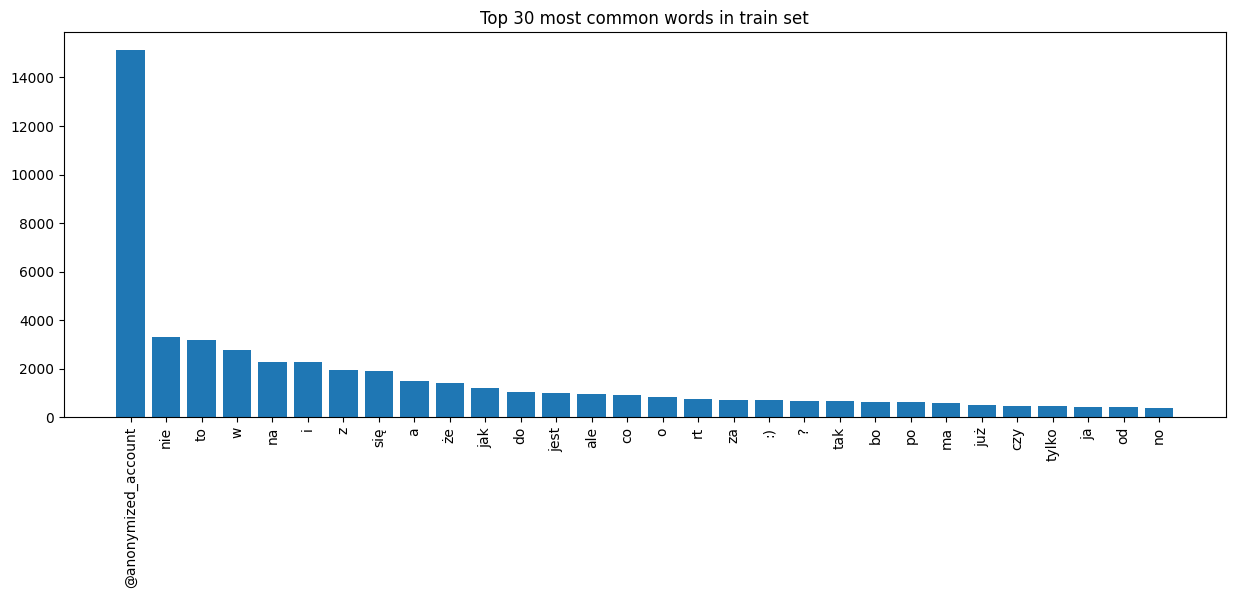

['RT @anonymized_account @anonymized_account M√≥wi cz≈Çowiek, kt√≥ry chcia≈Ç na≈Ço≈ºyƒá sankcje na Polskƒô. Gratulacje. #Niepodlegla #11lisopada', 'RT @anonymized_account doros≈Çe ≈ºycie nie jest dla mnie', 'RT @anonymized_account ‚ÄûTa aktorka ma 20 lat?!?! Jaka stara!!‚Äù \\n\\nChyba musimy siƒô ju≈º do grobu pakowaƒá roczniku 98 üòÇüëåüèª', 'RT @anonymized_account ≈öwiƒôtowaƒá uchwalenie Konstytucji 3 maja i ≈Çamaƒá Konstytucjƒô RP obecnie obowiƒÖzujƒÖcƒÖ?!\\n#3Maja - dzie≈Ñ hipokryzji.', 'RT @anonymized_account Jeszcze ≈ºaden Polak nie wystƒÖpi≈Ç w meczu gwiazd NBA, nie liczƒÖc Mietka Paciaciaka ;) Pom√≥≈ºmy Marcinowi Gortatowi byƒá 1‚Ä¶', 'RT @anonymized_account @anonymized_account @anonymized_account Ko≈Ñ by siƒô u≈õmia≈Ç, TVN24 i TVN wolne media? Bardziej perfidnego ≈Çgarstwa nie s≈Çysza≈Çem.. ü§î', 'RT @anonymized_account Na TVP Krak√≥w pad≈Ça w≈Ça≈õnie informacja ≈ºe rozmowy z potencjalnym kupcem Wis≈Çy prze≈Ço≈ºony z dzi≈õ na jutro.', 'RT @anonymized_account @anonymized_a

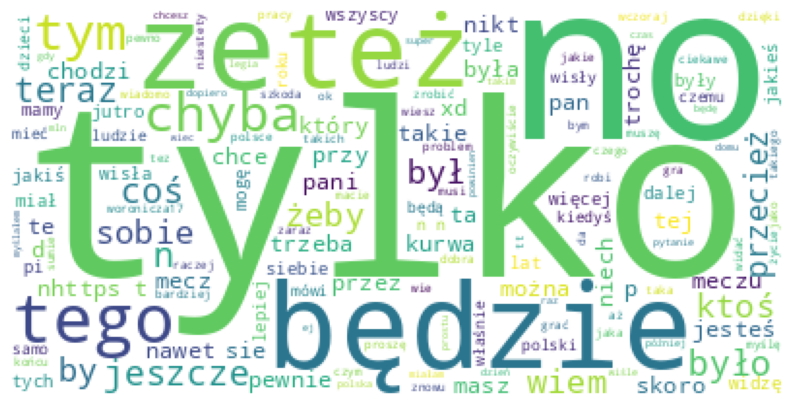

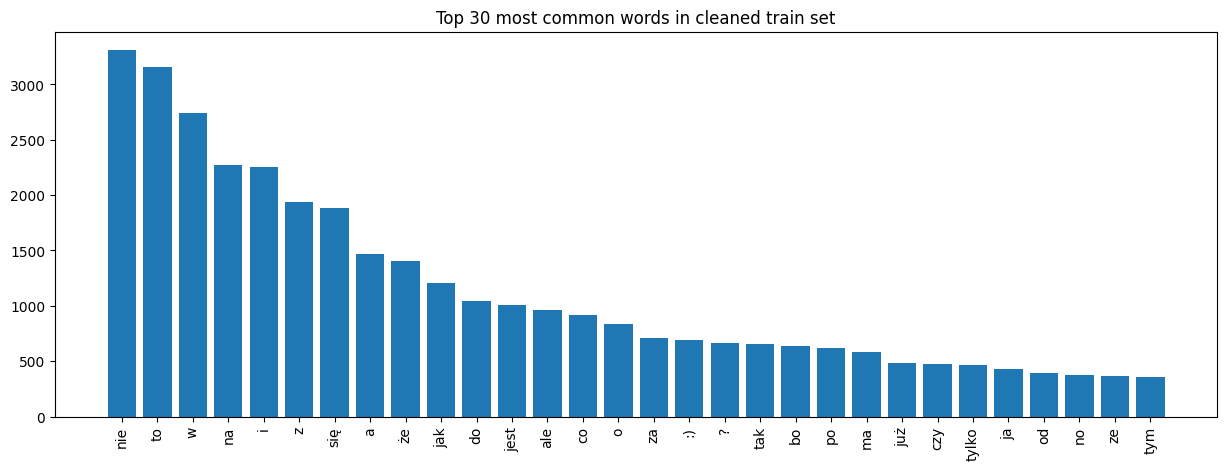

number of "NEGATIVE" comments: 10056 (91.08%).
Found 109789 words.


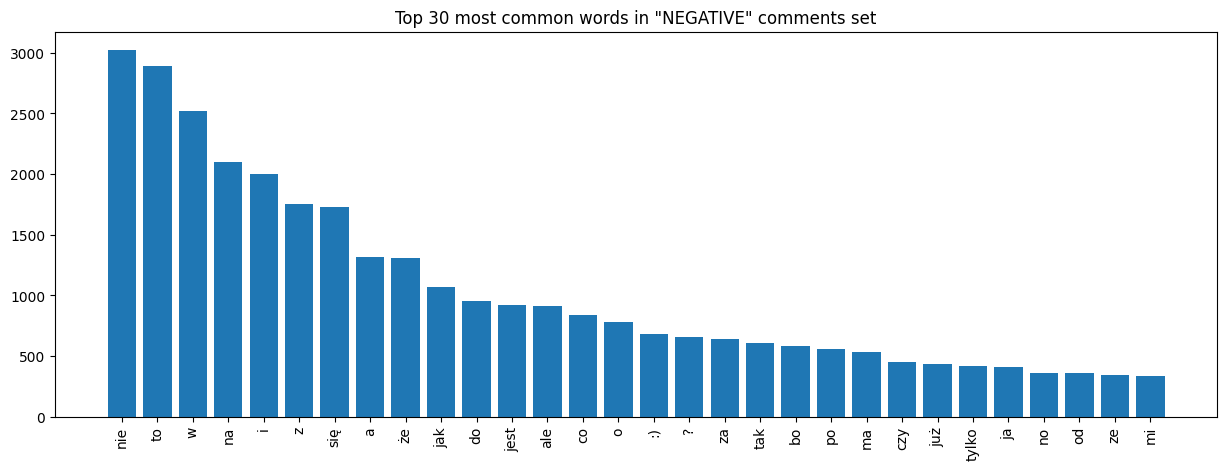

number of "POSITIVE" comments: 985 (8.92%).
Found 10832 words.


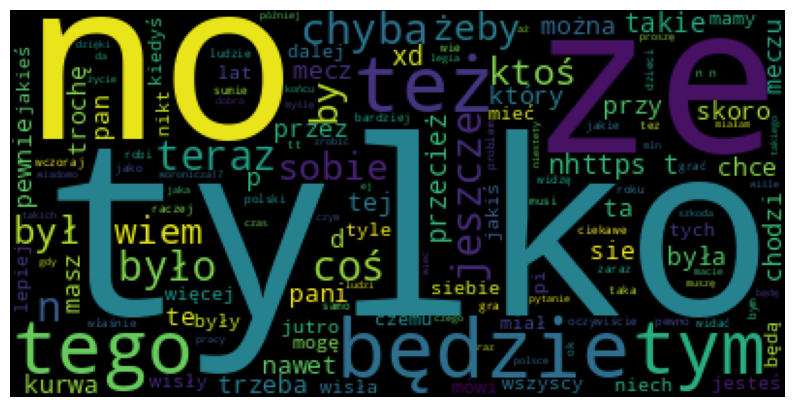

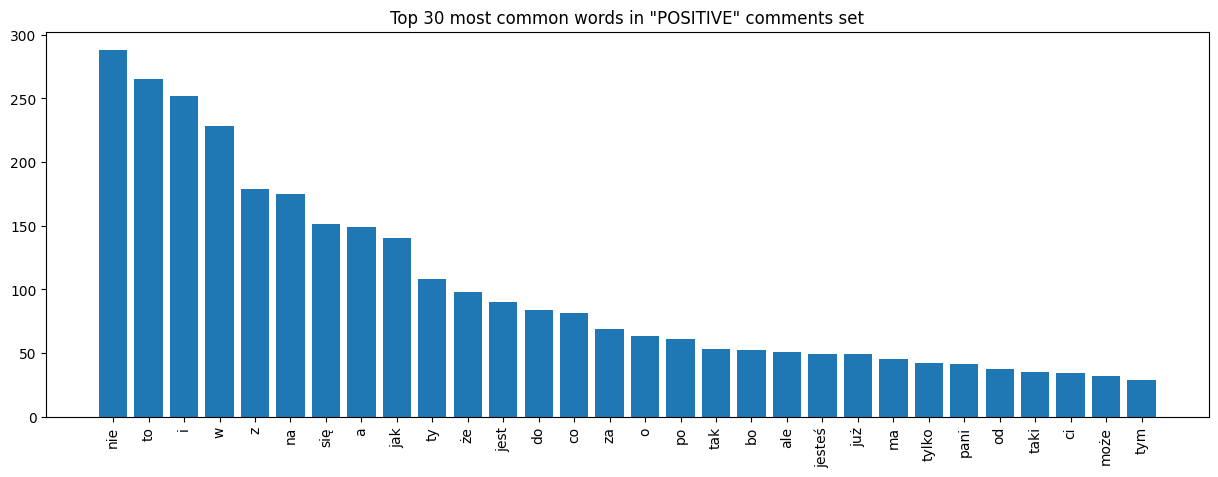

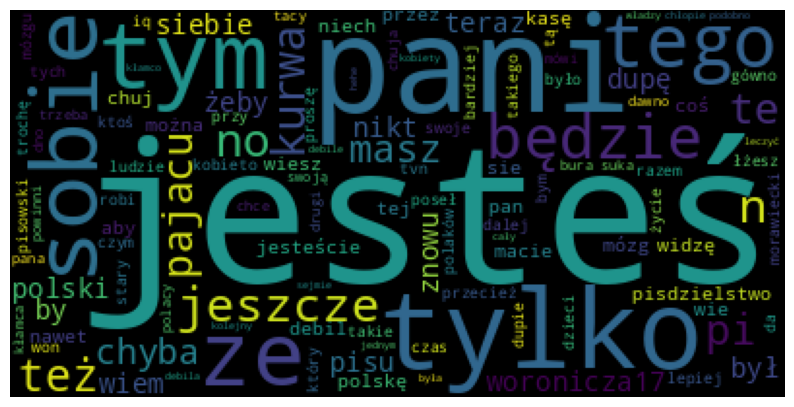

In [78]:
task_1_categories = {
    "1": "POSITIVE",
    1: "POSITIVE",
    "POSITIVE": 1,
    "0": "NEGATIVE",
    0: "NEGATIVE",
    "NEGATIVE": 0
}

(train_comments, train_labels), (test_comments, test_labels) = load_poleval_data(task_1_categories)

explore_data(train_comments, train_labels, test_comments, test_labels, task_1_categories)

In [79]:
check_unbalanced_nlp_model(train_comments, train_labels, test_comments, test_labels, task_1_categories)

KEY ADDED: POSITIVE
KEY ADDED: NEGATIVE
Training the model...
Epoch executed: 0
Epoch executed: 1
Epoch executed: 2
Epoch executed: 3
Epoch executed: 4
Epoch executed: 5
Epoch executed: 6
Epoch executed: 7
Epoch executed: 8
Epoch executed: 9
> Saved model as nlp_spacy_model_170500781571_unbalanced


Took 43.2177 second(s) ~0.72 minute(s).
y_true: Counter({0: 866, 1: 134})
y_pred: Counter({0: 983, 1: 17})

|   Accuracy |  Precision |   F1-Score |     Recall |
|      86.7% |      86.7% |      86.7% |      86.7% |


In [80]:
check_balanced_nlp_model(train_comments, train_labels, test_comments, test_labels, task_1_categories)

Counter({'NEGATIVE': 10056, 'POSITIVE': 985})
There is 91.08% of "NEGATIVE" comments
There is 8.92% of "POSITIVE" comments
985
Balanced data len: 1970
NEGATIVE | Pisowska pajƒôczyna, inwazja psychopolactwa a my trwamy i trwaƒá bƒôdziemy
NEGATIVE | Jak uniknƒÖƒá tych wnerwiajacych reklam na playerze
POSITIVE | @anonymized_account @anonymized_account Takie teksty to dla waszych pisofan√≥w. Wy my≈õlicie, ≈ºe jak wasi wyborcy to debile to reszta te≈º?
POSITIVE | @anonymized_account Chyba ciƒô frustracie do ko≈Ñca pojeba≈Ço. To dawaj publicznie tƒÖ prawdƒô psycholu.
POSITIVE | @anonymized_account @anonymized_account A ci co nie g≈Çosowali? Wszyscy jeste≈õcie pieprzonymi gnojami.
1576
394
NEGATIVE | pisowski pajƒôczyna inwazja psychopolactwo trwaƒá trwaƒá byƒá
NEGATIVE | uniknƒÖƒá wnerwiajacy reklama playerze
POSITIVE | tekst wasz pisofan my≈õlicie wyborca debile reszta
POSITIVE | chyba frustracie koniec pojebaƒá dawaƒá publicznie ten prawda psychol
POSITIVE | g≈Çosowaƒá jeste≈õcie pieprzony

In [81]:
check_logistict_regression(train_comments, train_labels, test_comments, test_labels, task_1_categories)

/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

Best parameter (CV score=0.918):
{'C': 1, 'solver': 'liblinear'}
Accuracy: 87.0%
Precision: 100.0%
f1_score: 5.8%
Recall: 2.99%


/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


> Labels converted to textcat format.

Train examples
| NON-HARMFULL | Dla mnie faworytem do tytu≈Çu bƒôdzie Cracovia. Zobaczymy, czy typ siƒô sprawdzi.
| NON-HARMFULL | @anonymized_account @anonymized_account Brawo ty Daria kibic ma byƒá na dobre i z≈Çe
| NON-HARMFULL | @anonymized_account @anonymized_account Super, polski premier sk≈Çada kwiaty na grobach kolaborant√≥w. Ale doczekali≈õmy czas√≥w.
| NON-HARMFULL | @anonymized_account @anonymized_account Musi. Innej drogi nie mamy.
| NON-HARMFULL | Odrzut natychmiastowy, kwa≈õna mina, mam problem
| NON-HARMFULL | Jaki on by≈Ç fajny xdd pamiƒôtam, ≈ºe sp√≥≈∫ni≈Çam siƒô na jego pierwsze zajƒôcia i to sporo i za karƒô kaza≈Ç mi usiƒÖ≈õƒá w pierwszej ≈Çawce XD

Test examples
| NON-HARMFULL | @anonymized_account Spoko, jak im Duda z Morawieckim zam√≥wiƒÖ po piƒôƒá piw to wszystko bƒôdzie ok.
| NON-HARMFULL | @anonymized_account @anonymized_account Ale on tu nie mia≈Ç szans jej zagrania, a ta 'proba' to czysta prowizorka.
| NON-HARMFULL | @a

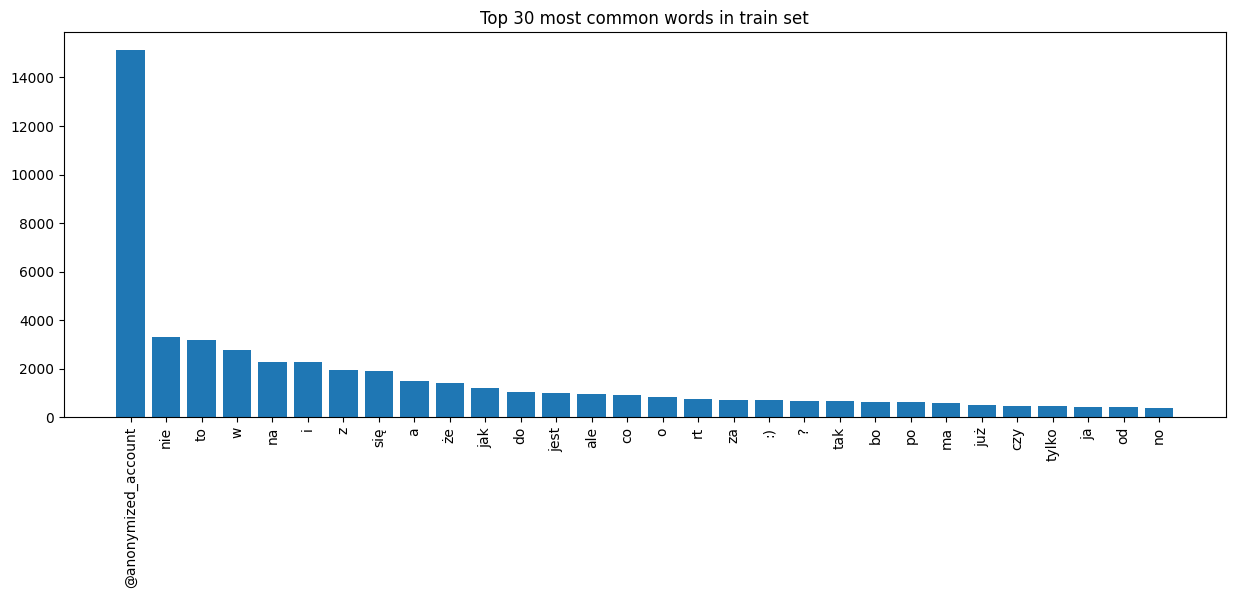

['RT @anonymized_account @anonymized_account M√≥wi cz≈Çowiek, kt√≥ry chcia≈Ç na≈Ço≈ºyƒá sankcje na Polskƒô. Gratulacje. #Niepodlegla #11lisopada', 'RT @anonymized_account doros≈Çe ≈ºycie nie jest dla mnie', 'RT @anonymized_account ‚ÄûTa aktorka ma 20 lat?!?! Jaka stara!!‚Äù \\n\\nChyba musimy siƒô ju≈º do grobu pakowaƒá roczniku 98 üòÇüëåüèª', 'RT @anonymized_account ≈öwiƒôtowaƒá uchwalenie Konstytucji 3 maja i ≈Çamaƒá Konstytucjƒô RP obecnie obowiƒÖzujƒÖcƒÖ?!\\n#3Maja - dzie≈Ñ hipokryzji.', 'RT @anonymized_account Jeszcze ≈ºaden Polak nie wystƒÖpi≈Ç w meczu gwiazd NBA, nie liczƒÖc Mietka Paciaciaka ;) Pom√≥≈ºmy Marcinowi Gortatowi byƒá 1‚Ä¶', 'RT @anonymized_account @anonymized_account @anonymized_account Ko≈Ñ by siƒô u≈õmia≈Ç, TVN24 i TVN wolne media? Bardziej perfidnego ≈Çgarstwa nie s≈Çysza≈Çem.. ü§î', 'RT @anonymized_account Na TVP Krak√≥w pad≈Ça w≈Ça≈õnie informacja ≈ºe rozmowy z potencjalnym kupcem Wis≈Çy prze≈Ço≈ºony z dzi≈õ na jutro.', 'RT @anonymized_account @anonymized_a

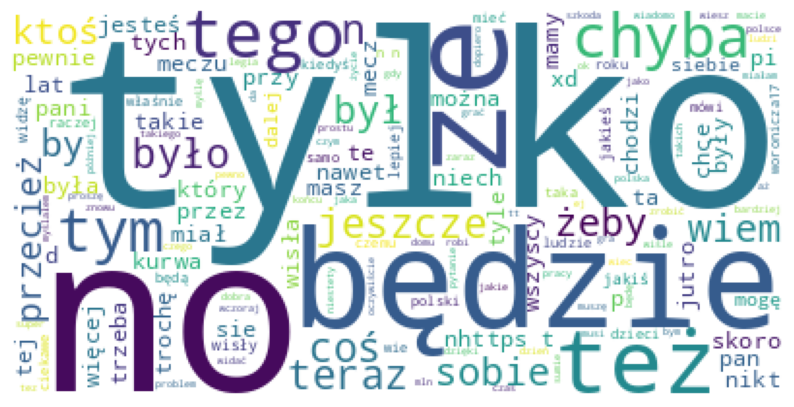

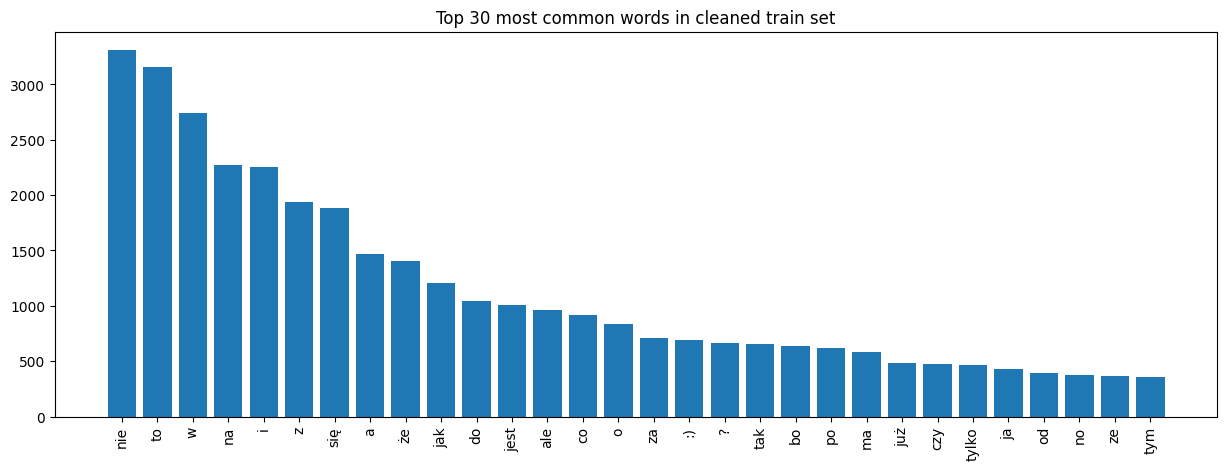

number of "NON-HARMFULL" comments: 10056 (91.08%).
Found 109789 words.


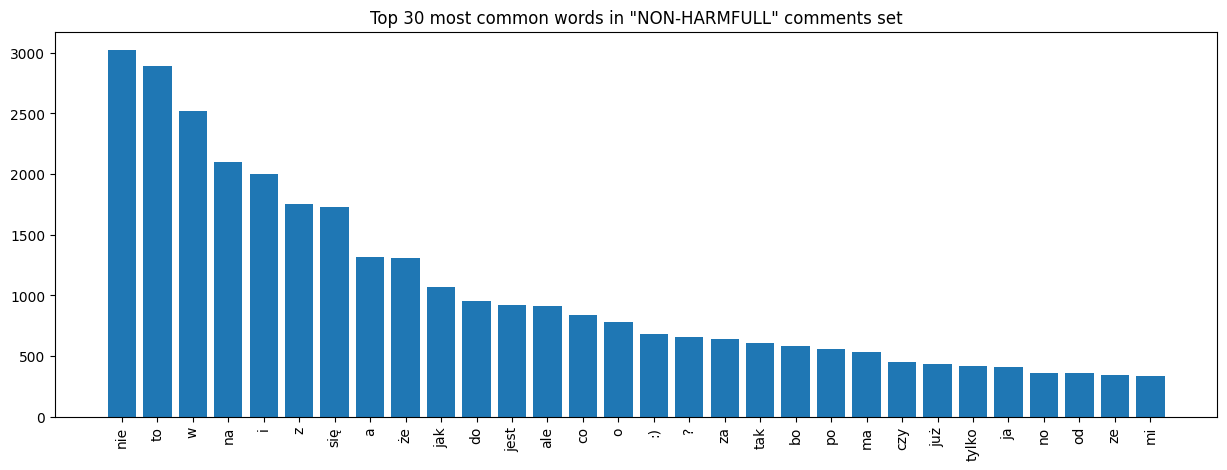

number of "HATE-SPEECH" comments: 707 (6.4%).
Found 7900 words.


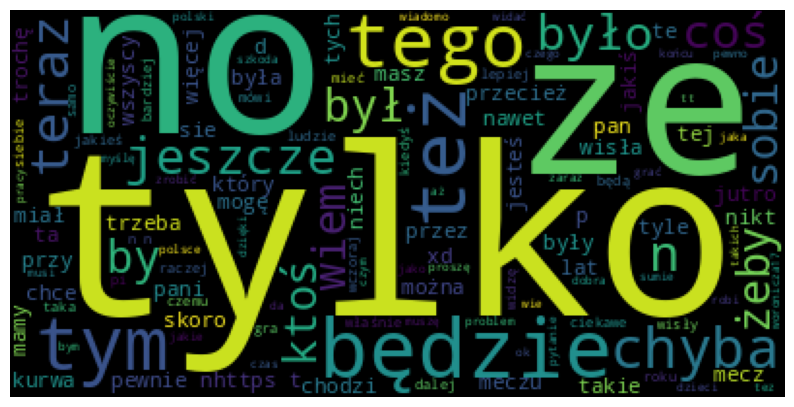

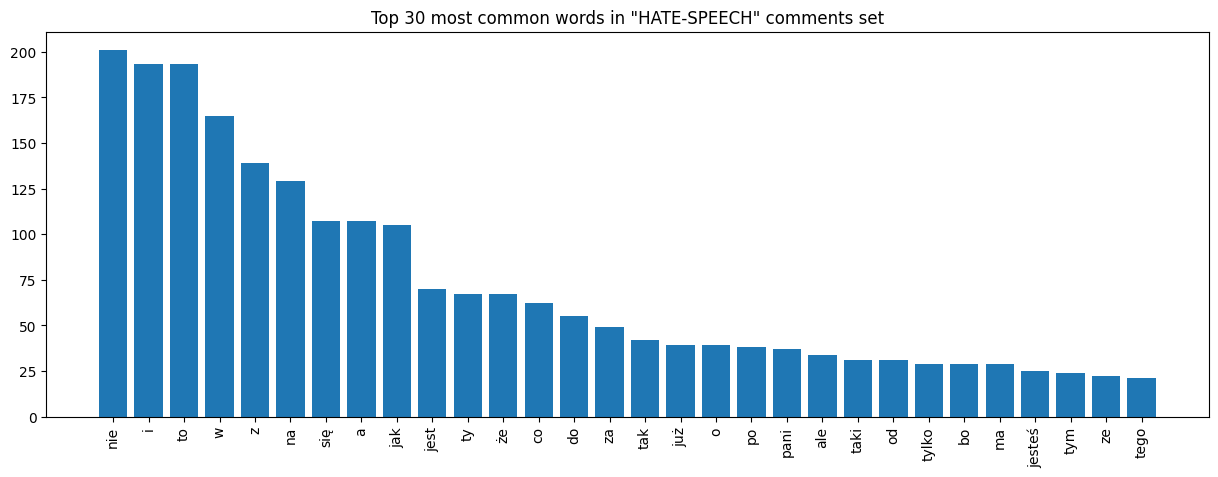

number of "CYBERBULLING" comments: 278 (2.52%).
Found 2932 words.


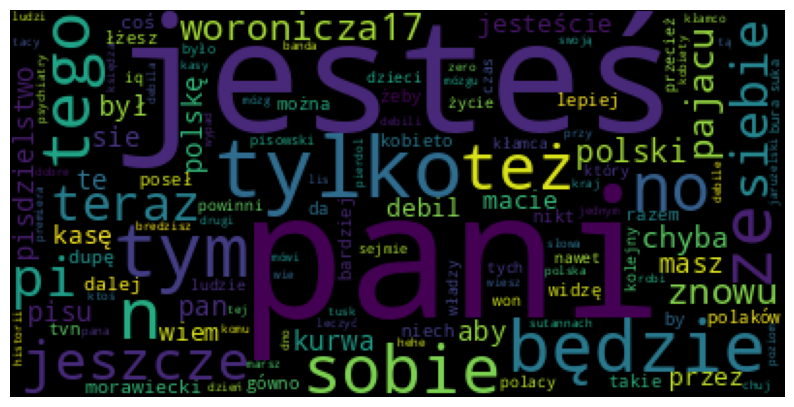

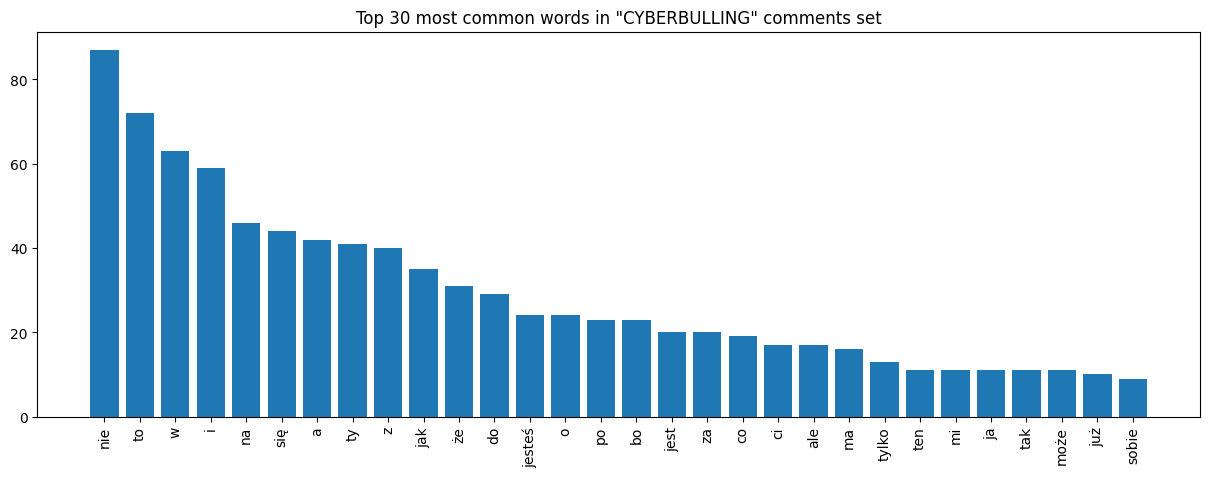

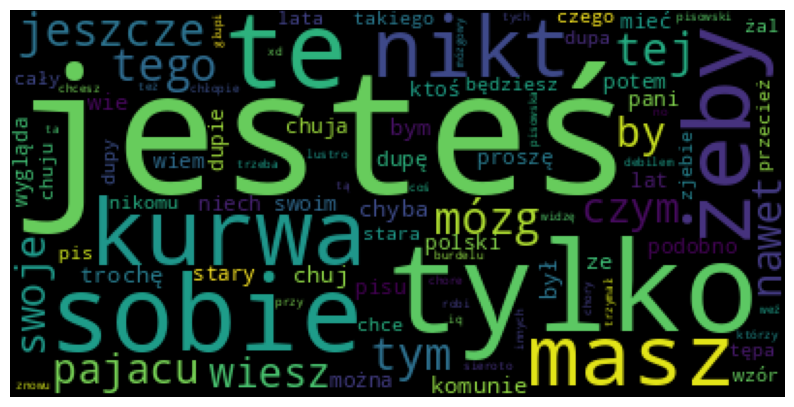

In [82]:
task_2_categories = {
    "0": "NON-HARMFULL",
    0: "NON-HARMFULL",
    "NON-HARMFULL": 0,
    "1": "CYBERBULLING",
    1: "CYBERBULLING",
    "CYBERBULLING": 1,
    "2": "HATE-SPEECH",
    2: "HATE-SPEECH",
    "HATE-SPEECH": 2,
}

(train_comments_task2, train_labels_task2), (test_comments_task2, test_labels_task2) = load_poleval_data(
    task_2_categories, 2)
explore_data(train_comments_task2, train_labels_task2, test_comments_task2, test_labels_task2, task_2_categories)

In [83]:
check_unbalanced_nlp_model(train_comments_task2, train_labels_task2, test_comments_task2, test_labels_task2,
                           task_2_categories)

KEY ADDED: NON-HARMFULL
KEY ADDED: CYBERBULLING
KEY ADDED: HATE-SPEECH
Training the model...
Epoch executed: 0
Epoch executed: 1
Epoch executed: 2
Epoch executed: 3
Epoch executed: 4
Epoch executed: 5
Epoch executed: 6
Epoch executed: 7
Epoch executed: 8
Epoch executed: 9
> Saved model as nlp_spacy_model_170500802395_unbalanced


Took 54.1764 second(s) ~0.9 minute(s).
y_true: Counter({0: 866, 2: 109, 1: 25})
y_pred: Counter({0: 982, 2: 11, 1: 7})

|   Accuracy |  Precision |   F1-Score |     Recall |
|      85.9% |      85.9% |      85.9% |      85.9% |


In [84]:
check_balanced_nlp_model(train_comments_task2, train_labels_task2, test_comments_task2, test_labels_task2,
                         task_2_categories)

Counter({'NON-HARMFULL': 10056, 'HATE-SPEECH': 707, 'CYBERBULLING': 278})
There is 91.08% of "NON-HARMFULL" comments
There is 6.4% of "HATE-SPEECH" comments
There is 2.52% of "CYBERBULLING" comments
278
Balanced data len: 834
NON-HARMFULL | Okno na ≈õwiat najskuteczniej zas≈Çania Gazeta... Polska.\nCo wspaniale wykorzystuje PiS trzymajƒÖc swe owieczki w cywilizacyjnych czworakach.
NON-HARMFULL | @anonymized_account Ju≈º drugi dzie≈Ñ. Wiƒôc jeszcze ze dwa üòÇ
CYBERBULLING | @anonymized_account @anonymized_account Bo jeste≈õ tak jebniƒôty jak @anonymized_account
NON-HARMFULL | Oddawaj pieniƒÖdze @anonymized_account @anonymized_account ludzkie oszusty, koniec ssania wszystkimi otworami, co tylko da siƒô wessaƒá
HATE-SPEECH | @anonymized_account Widzisz, i to jest r√≥≈ºnica miƒôdzy cz≈Çowiekiem inteligentnym a kim≈õ, komu apaszka odcina dop≈Çyw tlenu w do m√≥zgu.
667
167
NON-HARMFULL | okno ≈õwiat skutecznie zas≈Çaniaƒá gazeta polska.\nco wspaniale wykorzystywaƒá pis trzymaƒá sw√≥j owiecz

In [87]:
check_logistict_regression(train_comments_task2, train_labels_task2, test_comments_task2, test_labels_task2,
                           task_2_categories, "weighted")

/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/karol/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

Best parameter (CV score=0.915):
{'C': 0.1, 'solver': 'newton-cg'}
Accuracy: 86.7%
Precision: 85.97%
f1_score: 80.62%
Recall: 86.7%


/home/karol/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
